# Call of Duty: Warzone Player Data Analysis
## Introduction

![cod](./WZ.jpg)

Call of Duty: Warzone is a free-to-play battle royale video game released in 2020 by Activision. It can be played on PC, Xbox, and PlayStation. There are two main gamemodes: battle royale and plunder. In the battle royale mode you and 149 other people compete on the map and the goal is to be the last player or last team alive depending on which mode you queue into. The "safe zone" of the map gets smaller every couple minutes and if you aren't in it you die so it forces people to move and that forces people to run into each other and that is what makes sure the game doesn't last for hours. In the plunder mode the goal is to collect the most money. This tutorial will focus on the battle royale mode because it is a lot more popular and it is a lot more competitive, with there being occasional tournaments where players, usually professional players or streamers, can compete to win cash prizes. One of the biggest problem in the game since it was released is the amount of hackers in the game. These hackers can have hacks such as wall hacks that lets them see other players through walls or aimbot that allows them to hit every shot automatically. If you are playing a tournament when real money is on the line it would be very frustrating to run into a cheater, and even playing casually it isn't enjoyable to be killed by someone that is cheating. 

The goal of this tutorial is to look at player profile data to determine what actions in game lead to a better chance of winning and also using a players profile to predict whether they are cheating. The tutorial uses the [this dataset](https://github.com/adamulan/warzone-player-data-analysis/blob/main/wzdata.csv) and the following python packages:
- cloudscraper
- json
- pandas
- matplotlib
- seaborn
- sklearn



## Dataset

In order to do the analysis that I wanted to do I needed a set of player profile data that was labeled whether the player was a hacker or not and after some looking I realized that there was no such dataset available. I knew that there are a lot of websites that you can go on to look at your stats so I had to find one of those sites and find an api to pull data from. The site that I used is probably the one most people use to look at their stats and it is [cod.tracker.gg](https://cod.tracker.gg/warzone). The only problem is that they had no publicy documented APIs to use so it took more digging to eventually find the API endpoint that they use for players. I wrote the script below to pull player data and add it to a csv file and this can be used as is as long as you add a valid username to the player variable. 
> **_NOTE:_**  If the username of the player also has an identifier tag after it (not all usernames do) you need to make sure to include the whole thing ex. `player = 'timthetatman#4119609'`

> **_NOTE:_**  This only works for PC players not Xbox or PlayStation players

In [137]:
#import cloudscraper because the api is protected by cloudflare so normal requests doesn't work
import cloudscraper
import json

# player name and url - have to replace # with the URL Encoded version %23 so the request works
player = ''
player = player.replace('#','%23')
url = f'https://api.tracker.gg/api/v2/warzone/standard/profile/atvi/{player}'

# init scraper and get the url and make it a json object
scraper = cloudscraper.create_scraper()
response = scraper.get(url).text 
parse_json = json.loads(response)

# if the player isn't found throw an error
if 'error' in response:
    raise ValueError('Player not found make sure you have the right name and identifier if needed')

# parse the json to get all the data
name = parse_json['data']['platformInfo']['platformUserHandle']
average_life = parse_json['data']['segments'][1]['stats']['averageLife']['value']
contracts = parse_json['data']['segments'][1]['stats']['contracts']['value']
deaths = parse_json['data']['segments'][1]['stats']['deaths']['value']
downs = parse_json['data']['segments'][1]['stats']['downs']['value']
games_played = parse_json['data']['segments'][1]['stats']['gamesPlayed']['value']
kdr = parse_json['data']['segments'][1]['stats']['kdRatio']['value']
kills = parse_json['data']['segments'][1]['stats']['kills']['value']
score = parse_json['data']['segments'][1]['stats']['score']['value']
spg = parse_json['data']['segments'][1]['stats']['scorePerGame']['valueActivision']
spm = parse_json['data']['segments'][1]['stats']['scorePerMinute']['value']
time_played = parse_json['data']['segments'][1]['stats']['timePlayed']['value']
top10 = parse_json['data']['segments'][1]['stats']['top10']['value']
top25 = parse_json['data']['segments'][1]['stats']['top25']['value']
top5 = parse_json['data']['segments'][1]['stats']['top5']['value']
weekly_damage = parse_json['data']['segments'][1]['stats']['weeklyDamageDone']['value']
weekly_damage_pg = parse_json['data']['segments'][1]['stats']['weeklyDamagePerMatch']['value']
weekly_damage_pm = parse_json['data']['segments'][1]['stats']['weeklyDamagePerMinute']['value']
weekly_headshotpct = parse_json['data']['segments'][1]['stats']['weeklyHeadshotPct']['value']
weekly_kdr = parse_json['data']['segments'][1]['stats']['weeklyKdRatio']['value']
weekly_kills = parse_json['data']['segments'][1]['stats']['weeklyKills']['value']
weekly_kpg = parse_json['data']['segments'][1]['stats']['weeklyKillsPerGame']['value']
weekly_matches_played = parse_json['data']['segments'][1]['stats']['weeklyMatchesPlayed']['value']
weekly_spg = parse_json['data']['segments'][1]['stats']['weeklyScorePerGame']['value']
weekly_spm = parse_json['data']['segments'][1]['stats']['weeklyScorePerMinute']['value']
wins = parse_json['data']['segments'][1]['stats']['wins']['value']
wl_ratio = parse_json['data']['segments'][1]['stats']['wlRatio']['value']
classification = "n"
hacker = "no"

# build a string to add to the end of the csv file
csv_string = f'{name},{average_life},{contracts},{deaths},{downs},{games_played},{kdr},{kills},{score},{spg},{spm},{time_played},{top10},{top25},{top5},{weekly_damage},{weekly_damage_pg},{weekly_damage_pm},{weekly_headshotpct},{weekly_kdr},{weekly_kills},{weekly_kpg},{weekly_matches_played},{weekly_spg},{weekly_spm},{wins},{wl_ratio},{classification},{hacker}\n'

# add it to the end of the csv
with open('wzdata.csv','a') as fd:
    d.write(csv_string)


Now that I had a way to pull the data easier I had decide what players to pull. I decided that I wanted to include 3 categories of players into the dataset: content creators, hackers, and normal players. I decided to bring in content creators as a category because I was interested in how people that play the game for a living compare to casual players and hackers. I also knew that content creators have some of the best stats of players that aren't hackers so it would be good to include them in there to better represent the high end of non hackers so the model wouldn't misidentify them as hackers. The next category is hackers and names of hackers are difficult to find because they don't publicly disclose that they are hacking and they eventually get banned after enough people report them and someone manually bans them. So in order to find hackers I went to YouTube videos posted by the YouTuber [TimTheTatman](https://www.youtube.com/user/timthetatman) because I knew he posts videos spectating hackers and getting them banned. The last category is normal players and in order to get the normal players I went into the lobby of a content creator and got any player that I could. In the end I had 128 players with 29 columns of data and the breakdown was 87 normal players, 21 content creators, and 20 hackers. The pandas dataframe is below and the columns are as follows:
- name - Full username including identifier tag if it is needed
- average_life - Average time alive in seconds
- contracts - How many contracts they have completed in their lifetime
- deaths - How many deaths they have had in their lifetime
- downs - How many downs they have in their lifetime(down is different than kills becasue you can down a person and they can be revived by their teammate)
- games_played - Total games played in their lifetime
- kdr - Their lifetime kill death ratio
- kills - How many kills they have in their lifetime
- score - Total lifetime score (score is earned by doing a lot of different things during the game) 
- spg - Score per game
- spm - Score per minute
- time_played - Total time played 
- top10 - How many times the player has placed in the top 10
- top25 - How many times the player has placed in the top 25
- top5 - How many times the player has placed in the top 5
- weekly_damage - Amount of damage done in the last week
- weekly_damage_pg - Amount of damage done per game in the last week
- weekly_damage_pm - Amount of damage done per minute in the last week
- weekly_headshotpct - Headshot percent in last week
- weekly_kdr - Kill death ratio in the last week
- weekly_kills - Amount of kills in the last week
- weekly_kpg - Kills per game in the last week
- weekly_matches_played - Amount of games played in the last week
- weekly_spg - Score per game in the last week
- weekly_spm - Score per minute in the last week
- wins - Total lifetime wins
- wl_ratio - Win loss ratio
- classification - Classifiction of player(h for hacker, c for content creator, n for normal player)
- hacker - Whether the player is a hacker or not

In [139]:
import pandas as pd
df = pd.read_csv ('wzdata.csv')

df.head()

,name,average_life,contracts,deaths,downs,games_played,kdr,kills,score,spg,...,weekly_kdr,weekly_kills,weekly_kpg,weekly_matches_played,weekly_spg,weekly_spm,wins,wl_ratio,classification,hacker
0,timthetatman#4119609,418.668650,4643,9410,25369,3752,2.66,25016,23649788,6303.25,...,2.0393700787401574,259,4.18,62,3889.52,103.56,708,18.87,c,no
1,user42590#1961664,425.103067,5746,12196,54434,5776,4.36,53171,42853780,7419.28,...,2.5833333333333335,93,4.89,19,4750.0,131.28,860,14.89,c,no
2,cloakzy#1465165,472.157602,6125,10774,55564,4777,5.03,54247,43151004,9033.08,...,3.5140845070422535,499,6.93,72,6086.81,163.37,1143,23.93,c,no
3,Symfuhny#5773991,436.711155,13566,25145,117777,10587,4.40,110678,87703696,8284.09,...,4.461267605633803,1267,9.18,138,7280.69,175.36,2701,25.51,c,no
4,teep#7449135,491.651880,16002,21754,116294,9542,5.16,112161,91493208,9588.47,...,4.184684684684685,929,9.68,96,8761.82,207.55,2682,28.11,c,no


## Data Analysis

### Kill Death Ratio
The first thing I wanted to do was to see how hackers compared to non hackers and also how normal players compared to content creators and the first thing I wanted to look at is kill death ratio. I used a seaborn violin plot to see how the density differs for each group I also use the cut parameter so the graph didn't go below 0 since kill death ratios can't be negative. As mentioned above the h classification stands for hacker, the c classification stands for content creator, and the n classification stands for normal player. I would've liked to have all 3 classes in the same graph but the hacker one is just so different that you couldn't really tell what was going on with all 3 on the same graph. 

Text(0, 0.5, 'K/D')

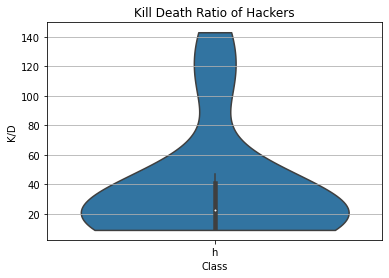

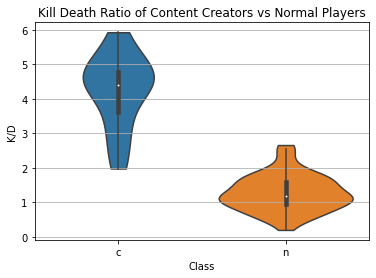

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

# get hacker df and plot it
fig, axes = plt.subplots()
sns.violinplot(x='classification',y='kdr', data=df.loc[(df['hacker'] == 'yes')], ax = axes,cut=0)
axes.set_title('Kill Death Ratio of Hackers')

axes.yaxis.grid(True)
axes.set_xlabel('Class')
axes.set_ylabel('K/D')

# get non hacker df and plot it
fig, axes = plt.subplots()
sns.violinplot(x='classification',y='kdr', data=df.loc[(df['hacker'] == 'no')], ax = axes,cut=0)
axes.set_title('Kill Death Ratio of Content Creators vs Normal Players')

axes.yaxis.grid(True)
axes.set_xlabel('Class')
axes.set_ylabel('K/D')

From these charts we can see that hackers have much higher kill death ratios than streamers and normal players and that is expected. We can also see on the chart between creators and normal players that the kill death ratio of streamers is much higher, so when you play the game for a living you are a lot more likely to have a higher kill death ratio. I expected it to be this way but I did not expect it to be that much higher. 

### Win Loss Ratio
The next thing I wanted to look at is win loss ratio. The graph is similar to the one above with the cut and the classes . 

Text(0, 0.5, 'W/L')

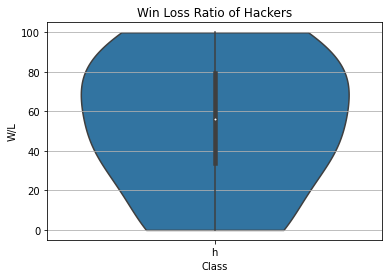

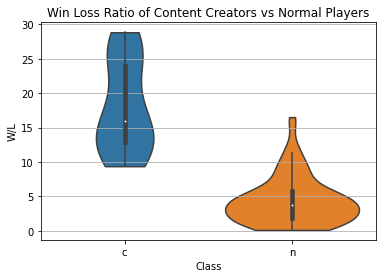

In [141]:
fig, axes = plt.subplots()

# get hacker df and plot it also cut off win loss ratio above 100 because for some reason there are win loss ratios above 100 in the data even though that isnt possible
sns.violinplot(x='classification',y='wl_ratio', data=df.loc[(df['hacker'] == 'yes') & (df['wl_ratio'] <= 100)], ax = axes,cut=0)
axes.set_title('Win Loss Ratio of Hackers')

axes.yaxis.grid(True)
axes.set_xlabel('Class')
axes.set_ylabel('W/L')

# get non hacker df and plot it
fig, axes = plt.subplots()
sns.violinplot(x='classification',y='wl_ratio', data=df.loc[(df['hacker'] == 'no')], ax = axes,cut=0)
axes.set_title('Win Loss Ratio of Content Creators vs Normal Players')

axes.yaxis.grid(True)
axes.set_xlabel('Class')
axes.set_ylabel('W/L')

From these charts we can see that hackers have a much higher spread of win loss than kill death. Similar to above on the chart between creators and normal players creators have a higer win loss rate. 

### Best Way to Win

The next thing I wanted to look at is to see what stats correlate to the highest win loss ratio so if I am playing the game I know what to focus on that would give me a better chance of winning.

###  Kill Death

The first thing I will look at is the correlation between kill death ratio and win loss ratio. It makes sense that if you have a high k/d ratio you are a pretty good player but if you are getting more kills that means you are fighting more and there is always the risk that you lose a fight so I want to see what the correlation is. 

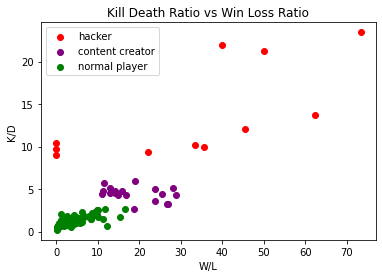

In [142]:
# break down dfs by class
cc_df = df.loc[(df['classification'] == 'c')]
# get rid of outliers in the hacker df to show more of the normal player difference
h_df = df.loc[(df['classification'] == 'h') & (df['wl_ratio'] < 100) & (df['kdr'] < 30) ]
n_df = df.loc[(df['classification'] == 'n')]

fig, ax = plt.subplots()

# scatter and label then show
ax.scatter(h_df['wl_ratio'],h_df['kdr'],color='red',label="hacker")
ax.scatter(cc_df['wl_ratio'],cc_df['kdr'],color='purple',label="content creator")
ax.scatter(n_df['wl_ratio'],n_df['kdr'],color='green',label="normal player")
ax.legend()
plt.title("Kill Death Ratio vs Win Loss Ratio")
plt.ylabel("K/D")
plt.xlabel("W/L")
plt.show()

From the graph we can see that there is a very vague linear relationship between k/d ratio and win loss ratio but it is not something I would say is conclusive evidence that higher kills leads to more wins. Obviously we can see that hackers can have very high k/d ratio and not always win games. 

###  Games played

The next thing I will look at is the correlation between games played and win loss ratio. It makes sense that if you play the game more you should always be getting better and get more wins as you play. 

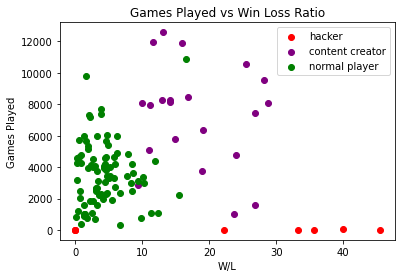

In [143]:
# break down dfs by class
cc_df = df.loc[(df['classification'] == 'c')]
# get rid of outliers in the hacker df to show more of the normal player difference
h_df = df.loc[(df['classification'] == 'h') & (df['wl_ratio'] < 50) & (df['kdr'] < 100) ]
n_df = df.loc[(df['classification'] == 'n')]

fig, ax = plt.subplots()

# scatter and label then show
ax.scatter(h_df['wl_ratio'],h_df['games_played'],color='red',label="hacker")
ax.scatter(cc_df['wl_ratio'],cc_df['games_played'],color='purple',label="content creator")
ax.scatter(n_df['wl_ratio'],n_df['games_played'],color='green',label="normal player")
ax.legend()
plt.title("Games Played vs Win Loss Ratio")
plt.ylabel("Games Played")
plt.xlabel("W/L")
plt.show()

From the graph we can see that there is really no relationship between games played and win loss ratio. We can see that most content creators have higher win loss ratio no matter how many games they have played. This relationship or lack thereof makes sense to me because I know from personal experience that you can play the game a lot but you will almost always run into someone that plays the game more than you or is just better so you can lose even if you play a lot. We can also see that most of the hackers never play that many games probably because they get banned before they can play that many. 

###  Score per Game

The next thing I will look at is the correlation between score per game and win loss ratio. To understand this graph we need to understand score better. There is no solid documentation of how score is calculated but just from the community playing the game it is understood that score goes up when you damage other players, get kills or downs, revive teammates, complete contracts, use killstreaks, and buy items. If you aren't familiar with the game theses are all different things you can do but don't necessarily need to do during a game.

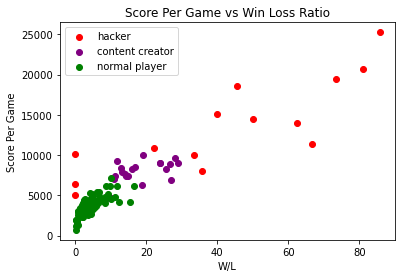

In [144]:
# break down dfs by class
cc_df = df.loc[(df['classification'] == 'c')]
# get rid of outliers in the hacker df to show more of the normal player difference
h_df = df.loc[(df['classification'] == 'h') & (df['wl_ratio'] < 100) & (df['kdr'] < 100) ]
n_df = df.loc[(df['classification'] == 'n')]

fig, ax = plt.subplots()

# scatter and label then show
ax.scatter(h_df['wl_ratio'],h_df['spg'],color='red',label="hacker")
ax.scatter(cc_df['wl_ratio'],cc_df['spg'],color='purple',label="content creator")
ax.scatter(n_df['wl_ratio'],n_df['spg'],color='green',label="normal player")
ax.legend()
plt.title("Score Per Game vs Win Loss Ratio")
plt.ylabel("Score Per Game")
plt.xlabel("W/L")
plt.show()

From the graph we can see that there is a pretty decent linear relationship between score and winning for normal players and that makes sense because if you are lasing longer in a game you are getting more score and if you last longer you have a better chance to win. 

###  Contracts Per Game

The next thing I will look at is the correlation between contracts per game and win loss ratio. Contracts are items that you can pick up in the games that give you a task that you have to complete that you get a reward for. An example of this is a bounty and you pick that up and it locates a player for you to kill and if you kill them you get money to spend in the game. Another example is a recon which marks a location that you have to go to and stand on for a period of time and it will give you items and it will show you where the next safe zone is. It can benefit you to do contracts but there is also a risk associated so it is a risk vs reward and will be interesting to see if they really help you win more. 

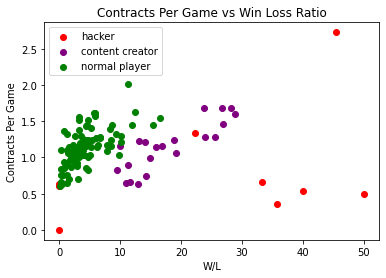

In [145]:
# calculate contracts per game and append to df
contract_pg = []
for index, row in df.iterrows():
    contract_pg.append(row['contracts']/ row['games_played'])
       
df["cpg"] = contract_pg

# break down dfs by class
cc_df = df.loc[(df['classification'] == 'c')]
# get rid of outliers in the hacker df to show more of the normal player difference
h_df = df.loc[(df['classification'] == 'h') & (df['wl_ratio'] < 60) & (df['kdr'] < 100) ]
n_df = df.loc[(df['classification'] == 'n')]

fig, ax = plt.subplots()

# scatter and label then show
ax.scatter(h_df['wl_ratio'],h_df['cpg'],color='red',label="hacker")
ax.scatter(cc_df['wl_ratio'],cc_df['cpg'],color='purple',label="content creator")
ax.scatter(n_df['wl_ratio'],n_df['cpg'],color='green',label="normal player")
ax.legend()
plt.title("Contracts Per Game vs Win Loss Ratio")
plt.ylabel("Contracts Per Game")
plt.xlabel("W/L")
plt.show()

From the graph we can see that there is really no relationship between doing more contracts and winning more games. I would've thought there'd be at least a little bit of a correlation, but from experience there are people that do contracts to find out where the end safe zone is and camp there and they usually get killed by better players even though they know where the safe zone will go.  

## Prediction

The last thing I want to do is use a decision tree to predict whether a player is a hacker or not. In order to do this I dropped a lot of rows from the dataframe then trained %80 of the data and tested %20. I had to drop all weekly data because after gathering the data I realized that almost all the hackers weekly data was null and that is because they were all banned months ago so they haven't played in the last week. I had hoped that it would be the last week that the player had played but that was not the case.

In [146]:
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# make the yes/no numbers so 
def numbertize(x):
    if x == "no":
        return 0
    else:
        return 1

x = df.drop(['name','weekly_damage','weekly_damage_pg','weekly_damage_pm','weekly_headshotpct','weekly_kdr','weekly_kills','weekly_kpg','weekly_matches_played','weekly_spg','weekly_spm','classification','hacker','cpg'], axis = 1)
y = df['hacker']

y = y.apply(numbertize)

# split the test data with %80 to train %20 to test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 5)

# train the decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

# predict the values for train and test set
y_pred_train = clf.predict(x_train) 
y_pred = clf.predict(x_test) 

# calculate error
mse = mean_squared_error(y_test,y_pred)
print('Mean Squared Error: ',mse)
rsq = r2_score(y_train,y_pred_train)
print('R-square, Training: ',rsq)
rsq = r2_score(y_test,y_pred)
print('R-square, Testing: ',rsq)


Mean Squared Error:  0.0
R-square, Training:  1.0
R-square, Testing:  1.0


As we can see the model is 100 percent accurate and that is good but also bad. The main issue with this model is how little data there is for it to train on. With a dataset this small it will fit the players that are included in the data well but there are millions of players that play the game so there has to be things in outside data that aren't reflected in this model. Also, one of the shortcomings of this model is that it only can detect people that are blatently hacking. It is possible and I would say somewhat likely that people could get sick of losing and download hacks and use them on an account that already has a lot of data that corresponds to not cheating and it would be hard for the model to pick that up unless they do it for a long time. This is mostly becasue the dataset that I used did not include weekly data for hackers. If the dataset had weekly hacker data the model would be able to pick up that something has changed with the players stats especially with the weekly headshot percent because most hackers use aimbots that only register headshots. It is also possible for players to hack and try to hide it and not have high kill games and be blatent about it and again this model wouldn't catch that.

### Try it yourself

Below is a script that you could use if you are playing a game of warzone and you are killed by a guy and think he may be hacking you can input his name into the player variable and run the script and it will pull profile data and make a prediction. In the prediction output 1 means hacker and 0 means not a hacker. In the script below I put the username of a hacker that was not in the original dataset and it identified him correctly. If you play warzone you can put your username in the player variable and see if it identifies you correctly and if you don't play the game you can set it to `'Atoxz58'`, that is my username and I am not a hacker and the model identifies me correctly. If you get an error make sure that your account is a PC account and that you have the correct identifier after your username. 

In [147]:
import cloudscraper
import json

# get url from player name
player = 'LuckyOwl#2724462'
player = player.replace('#','%23')
url = f'https://api.tracker.gg/api/v2/warzone/standard/profile/atvi/{player}'

# scrape data and make it json
scraper = cloudscraper.create_scraper()
response = scraper.get(url).text 
parse_json = json.loads(response)

# throw error 
if 'error' in response:
    raise ValueError('Player not found make sure you have the right name and identifier if needed')

test = []

# average life, contracts, deaths, downs, games_played,kdr, kills, score, spg, spm, time_played, top10, top25, top5, wins, wl_ratio
test.append(parse_json['data']['segments'][1]['stats']['averageLife']['value'])
test.append(parse_json['data']['segments'][1]['stats']['contracts']['value'])
test.append(parse_json['data']['segments'][1]['stats']['deaths']['value'])
test.append(parse_json['data']['segments'][1]['stats']['downs']['value'])
test.append(parse_json['data']['segments'][1]['stats']['gamesPlayed']['value'])
test.append(parse_json['data']['segments'][1]['stats']['kdRatio']['value'])
test.append(parse_json['data']['segments'][1]['stats']['kills']['value'])
test.append(parse_json['data']['segments'][1]['stats']['score']['value'])
test.append(parse_json['data']['segments'][1]['stats']['scorePerGame']['value'])
test.append(parse_json['data']['segments'][1]['stats']['scorePerMinute']['value'])
test.append(parse_json['data']['segments'][1]['stats']['timePlayed']['value'])
test.append(parse_json['data']['segments'][1]['stats']['top10']['value'])
test.append(parse_json['data']['segments'][1]['stats']['top25']['value'])
test.append(parse_json['data']['segments'][1]['stats']['top5']['value'])
test.append(parse_json['data']['segments'][1]['stats']['wins']['value'])
test.append(parse_json['data']['segments'][1]['stats']['wlRatio']['value'])

print(test)
print(f"Prediction: {clf.predict([test])[0]}")


[843.0, 16, 17, 621, 11, 30.71, 522, 271050, 24640.91, 1138.87, 14331, 9, 10, 9, 9, 81.82]
Prediction: 1


## Conclusion
Overall, I think you should be able to look at this tutorial and gain some insight about warzone and player data in warzone. I certainly found it interesting to see how certain stats relate to each other. The biggest problem with this tutorial is how little data it relies on. To gain insight on normal players vs creators and hackers it works fine but it certainly wouldn't be practical to use this model in the actual game because there is just far too little data it is trained on. It would've been nice if Activision had published large datasets of warzone data because it would certainly interest me to see how well hacking could be predicted just using data. Recently, Activision has said that there is an anti-cheat being tested for warzone and it is a kernel-level driver that would detect it in a different way than just using data, but the game has been out for over a year and there are blatent hackers that are still getting away and I feel like if I was able to throw together a model with a small amount of data that is at least somewhat correct then a billion dollar company should be able to do better. 


Project Repo: https://github.com/adamulan/warzone-player-data-analysis